In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import pickle as pkl
from tabulate import tabulate

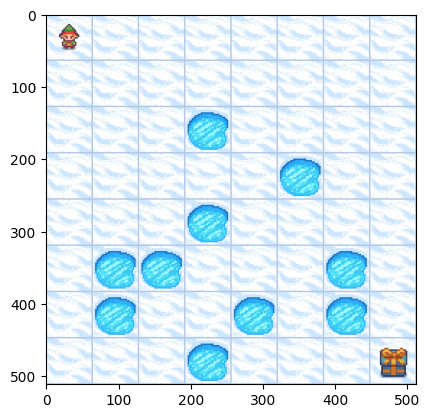

In [4]:
# Create the environment
env  = gym.make('FrozenLake-v1', is_slippery=True, map_name='8x8', render_mode='rgb_array')    
grid_height, grid_width  = env.unwrapped.desc.shape
env.reset()
plt.imshow(env.render())

In [5]:
print('='*40)
print('Environment Spaces:\n')
print(f'Observation Space: {env.observation_space}')
print(f'Action Space:      {env.action_space} ')
print('='*40)

Environment Spaces:

Observation Space: Discrete(64)
Action Space:      Discrete(4) 


In [6]:
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(64, 4)

In [7]:
# I am gonna use this helper function, that I got from lecture note
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

In [8]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)
# I got this helper function from lecture note  

In [9]:
# Hyperparameters: 

# I increased the number of episodes, because the environment is more complex 
episodes = 70000
# Since Frozen lake is slippery and has 64 states, I increased the number of steps
max_steps = 200
# For learning stability, I decreased the learning rate
learning_rate = 0.3
gamma = 0.95
# For giving more chance to exploration, I increased the epsilon         
epsilon = 1.0        
max_epsilon = 1.0
min_epsilon = 0.07
decay_rate = 0.0001

### Training Loop

In [10]:
for episode in range(episodes):

    state, __ = env.reset()
    done = False
    total_reward = 0
    step = 0
    
    while not done and step < max_steps:
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(Q_table[state, :])
        else:
            action = env.action_space.sample()
            
        
        next_state, reward, done, truncated, __ = env.step(action)
        # I am gonna penalize each step taken 
        reward = reward - 0.01  
        
        if done and reward <=0:
            # -1 reward for falling in the hole
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, next_state, learning_rate, gamma)
            total_reward += reward
            break 
        
        Q_table = calculate_value(Q_table, state, action, reward, next_state, learning_rate, gamma)
        state = next_state  
        total_reward += reward
        step += 1
        
        if done:
            print(f'Step taken:{step}')
            break
        
        # Save the Q-table
        if episode % 70000 == 0:
            with open('data/q_table.pkl', 'wb') as f:
                pkl.dump(Q_table, f)
                
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    if total_reward >=0 :
        print(f"Episode {episode} done with total rewards: {total_reward:.3f}, epsilon: {epsilon:.3f}")
# I got the main structure of the code from the lecture note. 

Step taken:110
Step taken:53
Episode 861 done with total rewards: 0.470, epsilon: 0.923
Step taken:49
Episode 1239 done with total rewards: 0.510, epsilon: 0.892
Step taken:71
Episode 1423 done with total rewards: 0.290, epsilon: 0.877
Step taken:65
Episode 1481 done with total rewards: 0.350, epsilon: 0.872
Step taken:40
Episode 1496 done with total rewards: 0.600, epsilon: 0.871
Step taken:124
Step taken:34
Episode 2090 done with total rewards: 0.660, epsilon: 0.825
Step taken:64
Episode 2432 done with total rewards: 0.360, epsilon: 0.799
Step taken:94
Episode 2535 done with total rewards: 0.060, epsilon: 0.792
Step taken:57
Episode 2744 done with total rewards: 0.430, epsilon: 0.777
Step taken:94
Episode 2862 done with total rewards: 0.060, epsilon: 0.769
Step taken:33
Episode 2976 done with total rewards: 0.670, epsilon: 0.761
Step taken:72
Episode 3030 done with total rewards: 0.280, epsilon: 0.757
Step taken:53
Episode 3420 done with total rewards: 0.470, epsilon: 0.731
Step take

In [11]:
# Applying the summarize best value function
best_values = summarize_best_values(Q_table, grid_width, grid_height)
print('Q_table after Training:')
print(tabulate(best_values, tablefmt='fancy_grid', floatfmt='.2f'))

Q_table after Training:
╒═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ -0.14 │ -0.14 │ -0.12 │ -0.11 │ -0.09 │ -0.08 │ -0.07 │ -0.06 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.15 │ -0.14 │ -0.13 │ -0.10 │ -0.09 │ -0.09 │ -0.05 │ -0.03 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.17 │ -0.18 │ -0.22 │  0.00 │ -0.16 │ -0.08 │ -0.05 │  0.05 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.18 │ -0.29 │ -0.38 │ -0.61 │ -0.49 │  0.00 │ -0.02 │  0.20 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.19 │ -0.47 │ -0.64 │  0.00 │ -0.51 │ -0.32 │ -0.08 │  0.31 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.20 │  0.00 │  0.00 │ -0.80 │ -0.54 │ -0.38 │  0.00 │  0.48 │
├───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ -0.20 │  0.00 │ -0.90 │ -0.84 │  0.00 │ -0.23 │  0.00 │  0.81 │
├───────┼───────┼───────┼───────┼───────┼───────┼───

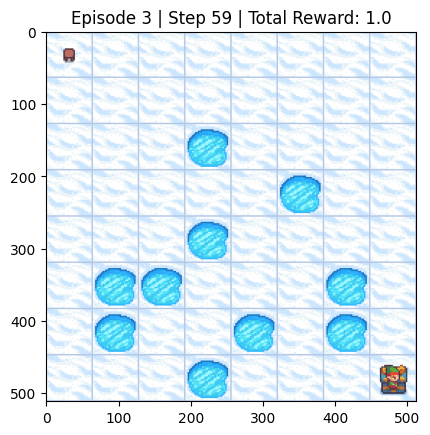

In [13]:
# I got the main structure of the code from the lecture note
for episode in range(3):
    state, _ = env.reset()
    done = False
    total_rewards = 0
    step = 0
    
    while not done and step < max_steps:
        # Action selection  
        action = np.argmax(Q_table[state, :])
        
        # Environment step
        observation, reward, done, truncated, _ = env.step(action)
        total_rewards += reward
        state = observation
        
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.title(f'Episode {episode+1} | Step {step} | Total Reward: {total_rewards}')
        plt.pause(0.01)  
        
        
        if done:
            time.sleep(1)  
            break
        
        step += 1   
        

env.close()
plt.close()